# Deep learning for AI detection

The purpose of this project is to show how machine learning methods can be used to identify AI-generated text.

## Dataset

I generated all the AI text using the GPT-3.5 Turbo API, and compiled the human text from a variety of online sources. There are three different styles of writing in the testing and training data:
1. Opinion/argumentation: the human texts comprised a selection of IMDB reviews compiled by the Andrew Maas group at the Stanford AI lab, the AI texts comprised responses from the GPT-3.5 Turbo API upon prompting to write reviews on 410 movies consisting of the top 10 films by US box office in the years 1980-2020.<br>
The prompts used were:<br>
   *Please write a [positive, negative, mildly positive, mildly negative, neutral] review about the [YEAR] movie [MOVIE] from the perspective of a casual moviegoer[, without mentioning the name of the movie, the name of the director, the year of release, or using the phrase 'casual moviegoer.']*
2. Narrative/creative writing: the human texts comprised original Reddit posts in the r/relationship_advice and r/AITA subreddits, which consisted of a mixture of presumably real life stories and fantasy, and the AI texts comprised responses from the GPT-3.5 Turbo API upon prompting to write Reddit posts with the same titles.<br>The prompts used were:<br>
*Please write a post in the r/[AITA,relationship_advice] subreddit with the following title: [TITLE]*
3. Informative: the human texts comprised the introductory paragraphs of 4023 wikipedia articles selected at random, covering a wide variety of topics (biographical, political, historical, scientific, sports and entertainment), the AI texts comprised responses from GPT-3.5 Turbo API upon prompting to write an encyclopedia-style introduction to the topic.<br>The prompts used were:<br>
*Please write a wikipedia-style introduction to the following topic of approximately 600 words, without sections or a concluding or summary sentence: [TITLE]*

Details of the data wrangling used to prepare the data for machine learning and the train-test split can be found in a separate notebook (data_wrangling.ipynb)

## Import the data, libraries, generate training/validation split
Let's import the training data, and split it into a training and validation set:

In [1]:
import shutil
home = '/kaggle/input/ml-for-author-identification-train-test/'

In [2]:
import pandas as pd

train_samples = pd.read_csv(home + 'train.csv')

train = train_samples[train_samples['TTV split'] != 0]
val = train_samples[train_samples['TTV split'] == 0]

display(train)
display(val)

,text,source,topic,TTV split,label
0,I can't honestly believe that this is a sequel...,imdb,movie review,1.0,0
1,20th Century Fox's ROAD HOUSE 1948) is not onl...,imdb,movie review,4.0,0
2,"I am a fan of Jess Franco's bizarre style, and...",imdb,movie review,2.0,0
3,"(No need to recap the plot, since others have ...",imdb,movie review,3.0,0
4,"I ticked the ""contains spoiler"" box, in case I...",imdb,movie review,3.0,0
...,...,...,...,...,...
19426,The Louisville Cardinals men's soccer team is ...,wikipedia by GPT,Louisville Cardinals men's soccer,4.0,1
19427,"KFC Yum! Center, also known as the Yum! Center...",wikipedia by GPT,KFC Yum! Center,4.0,1
19428,The 2020–21 Louisville Cardinals men's basketb...,wikipedia by GPT,2020–21 Louisville Cardinals men's basketball ...,4.0,1
19429,Conte Forum is a multi-purpose indoor arena lo...,wikipedia by GPT,Conte Forum,4.0,1


,text,source,topic,TTV split,label
6,"With the death of her infirmed husband, May, a...",imdb,movie review,0.0,0
23,Spider-Man is in my opinion the best superhero...,imdb,movie review,0.0,0
27,Diora Baird is absolutely hot as hell in this ...,imdb,movie review,0.0,0
32,Family Guy is THE best show on TV. EVER. It ha...,imdb,movie review,0.0,0
34,"Straight to the point: ""The Groove Tube"" is on...",imdb,movie review,0.0,0
...,...,...,...,...,...
16735,Floating licensing is a software licensing mod...,wikipedia by GPT,Floating licensing,0.0,1
16736,Software copyright refers to the legal protect...,wikipedia by GPT,Software copyright,0.0,1
16737,The Indian Copyright Act is a legislation that...,wikipedia by GPT,Indian Copyright Act,0.0,1
16738,The Copyright law of France represents a funda...,wikipedia by GPT,Copyright law of France,0.0,1


Next we import the libraries required for deep learning:

In [3]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.callbacks import EarlyStopping,Callback,ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.saving import load_model

import subprocess as sp
import os
import gc

## Prepare the data for input

The first layer of text processing will be byte-pair encoding (BPE). We will train a BPE tokenizer on the training data:

In [4]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

BPE_tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
BPE_tokenizer.pre_tokenizer = Whitespace()
BPE_tokenizer.train_from_iterator(train['text'], trainer=trainer)

def tokenizer(text):
    return [str(t) for t in BPE_tokenizer.encode(text).ids]

In [5]:
tokenizer('Please believe me, I am not a cat.')

['7467', '3062', '1742', '16', '45', '1711', '1810', '69', '4133', '18']

We will create a vectorizer layer that takes the tokenized texts as input and transforms it into an appropriate form for input to the neural network.

In [6]:
from collections import Counter

seq_length = 2048

def create_vectorizer(corpus):
    vocab = Counter(corpus.split())
    vocab_list = vocab.keys()
    text_dataset = tf.data.Dataset.from_tensor_slices(vocab_list)
    vocab_size = len(vocab_list)+1
    vectorize_layer = tf.keras.layers.TextVectorization(
        max_tokens=None,
        output_mode='int',
        output_sequence_length=seq_length,
        standardize = None)

    vectorize_layer.adapt(text_dataset)
    return vectorize_layer,vocab,vocab_size

Next we tokenize the training samples and train our vectorizer layer:

In [7]:
%%time
train['tokenized'] = train['text'].apply(lambda x: ' '.join(tokenizer(x)))
val['tokenized'] = val['text'].apply(lambda x: ' '.join(tokenizer(x)))

<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 21.5 s, sys: 0 ns, total: 21.5 s
Wall time: 21.6 s


<timed exec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
%%time
vectorize_layer,vocab,vocab_size = create_vectorizer(' '.join(train['tokenized']))

print(f"Vocab size: {vocab_size}")

Vocab size: 29327
CPU times: user 1min 24s, sys: 13 s, total: 1min 37s
Wall time: 59.2 s


We will use our vectorizer layer to vectorize the text inputs and one-hot encode the labels.

In [9]:
%%time

X_train = vectorize_layer(train['tokenized'].tolist()).numpy()
X_val = vectorize_layer(val['tokenized'].tolist()).numpy()

y_train = np.array(train['label'].map({0: [1,0], 1: [0,1]}).tolist())
y_val = np.array(val['label'].map({0: [1,0], 1: [0,1]}).tolist())

CPU times: user 2.33 s, sys: 943 ms, total: 3.27 s
Wall time: 3.51 s


## Create and train the models

We will now explore models consisting of an embedding layer, either a single feedforward layer or a single LSTM, and either no attention layer or an attention layer implementing scaled dot product or soft attention. I use dropout to regularize the model during training. There are three hyperparameters: the embedding dimension, the number of units in the feedforward or LSTM layers, and the dropout rate. The memory and time requirements are significantly higher when an LSTM layer is present, when the embedding dimension or number of units is higher, and when an attention mechanism is implemented. For the values of the embedding dimension and number of units I will use both 16 and 64, except in the case of LSTMs with attention, in which case I will fix them both to the lower value of 16 due to memory limitations.

I will use the validation data to perform hyperparameter tuning and model selection: I fit the models for a maximum of 100 epochs, but stop fitting early based on monitoring the validation loss. Since the validation loss does not necessarily monotonically increase after the minimum has been reached, I will allow a "patience" of ten epochs (i.e. stop the fitting if the validation loss has not improved for the previous ten epochs) and save the model with the best validation loss. This will require careful learning rate scheduling in order to ensure that we reach the minimum validation loss, and that it does not too quickly rapidly increase in the succeeding epochs.

In [10]:
from tensorflow import math, matmul, reshape, shape, transpose, cast, float32
from tensorflow.keras import backend as K

import numpy as np

class SoftAttention(Layer):
    def __init__(self,**kwargs):
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(SoftAttention, self).build(input_shape)

    def call(self,x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        e = K.squeeze(e, axis=-1)
        alpha = K.softmax(e)
        alpha = K.expand_dims(alpha, axis=-1)
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

class ScaledDotProductAttention(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, queries, keys, values, d_k, mask=None):
        scores = matmul(queries, keys, transpose_b=True) / math.sqrt(cast(d_k, float32))
        if mask is not None:
            scores += -1e9 * mask
        weights = K.softmax(scores)
        return matmul(weights, values)

In [11]:
class AI_detector:
    def __init__(self, vocab_size, embedding_dim, seq_length, lr_scheduler, learning_rate):
        self.vocab_size = vocab_size+1
        self.embedding_dim = embedding_dim
        self.seq_length = seq_length
        self.lr_scheduler = lr_scheduler
        self.learning_rate = learning_rate

    def create(self, n_ff, n_lstm, attention_type, dense_units, hidden_units, dropout, verbose=False):
        inputs = Input(shape=(self.seq_length,))
        x = Embedding(self.vocab_size, self.embedding_dim, input_length = self.seq_length)(inputs)

        for _ in range(n_lstm):
            x = LSTM(hidden_units, return_sequences=True, dropout=dropout)(x)

        if attention_type == 'soft':
            x = SoftAttention()(x)
        elif attention_type == 'sdp':
            attention = ScaledDotProductAttention()(x,x,x,self.embedding_dim)
            x = tf.reduce_sum(attention, axis=1)
        else:
            if attention_type != None:
                print(f"Attention type {attention_type} not recognized.")

        x = Flatten()(x)
        for _ in range(n_ff):
            x = Dense(dense_units)(x)
            x = Dropout(dropout)(x)
        outputs = Dense(2, activation='softmax')(x)
        model = Model(inputs=inputs, outputs=outputs)

        if verbose:
            model.summary()
        self.model = model

    def fit(self, X_train, y_train, batch_size=32, validation_data=None, model_path=None, save=False, save_best_only=True):
        if validation_data != None:
            monitor = 'val_loss'
        else:
            monitor = 'loss'

        callbacks = [LearningRateScheduler(self.lr_scheduler), EarlyStopping(monitor=monitor, patience=patience)]

        if save:
            callbacks.append(ModelCheckpoint(filepath=model_path, monitor=monitor, mode='min', save_best_only=True))

        self.model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=self.learning_rate), metrics = ['accuracy'])

        if validation_data != None:
            return self.model.fit(X_train, y_train, epochs = epochs, validation_data = validation_data, batch_size = batch_size, callbacks = callbacks, verbose = 1)
        else:
            return self.model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, callbacks = callbacks, verbose = 1)

In [12]:
def lr_scheduler(epoch, lr):
    if epoch+1 <= warmup:
        return learning_rate
    return learning_rate*np.power(epoch+1-warmup, decay_power)

In [13]:
#os.mkdir("models")

def get_model_path(embedding_dim, n_ff, n_lstm, attention_type, units, dropout):
    return "models/"+f"model_{embedding_dim}_{'FF' if n_lstm==0 else 'LSTM'}_{'' if attention_type == None else attention_type}_{units}_{dropout}"

def train_model(embedding_dim, n_ff, n_lstm, attention_type, units, dropout):
    model = AI_detector(vocab_size, embedding_dim, seq_length, lr_scheduler, learning_rate)
    model_path = get_model_path(embedding_dim, n_ff, n_lstm, attention_type, units, dropout)
    model.create(n_ff, n_lstm, attention_type, units, units, dropout)
    print(f"Built model with embedding_dim = {embedding_dim}, n_ff = {n_ff}, n_lstm = {n_lstm}, attention_type = {attention_type}, units = {units}, dropout = {dropout}")
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        batch_size=batch_size, save=True,
                        model_path=model_path)
    print("Saved model to " + model_path)
    K.clear_session()

In [14]:
epochs = 100
patience = 10

def train_models_1():
    global learning_rate
    global warmup
    global decay_power
    global batch_size
    
    learning_rate = 1e-4
    warmup = 8
    decay_power = -0.5
    batch_size=64

    for FF in [True, False]:
        for embedding_dim in [16, 64]:
            for units in [16, 64]:
                for dropout in [0.2,0.5]:
                    train_model(embedding_dim, 1 if FF else 0, 0 if FF else 1, None, units, dropout)
    

def train_models_2():
    global learning_rate
    global warmup
    global decay_power
    global batch_size

    learning_rate = 1e-4
    warmup = 5
    decay_power = -0.5
    batch_size=32

    for embedding_dim in [16, 64]:
        for units in [16, 64]:
            for dropout in [0.2,0.5]:
                train_model(embedding_dim, 1, 0, 'sdp', units, dropout)
        
def train_models_3():
    global learning_rate
    global warmup
    global decay_power
    global batch_size

    learning_rate = 5e-4
    warmup = 10
    decay_power = -0.25
    batch_size=32

    for embedding_dim in [16, 64]:
        for units in [16, 64]:
            for dropout in [0.2,0.5]:
                train_model(embedding_dim, 1, 0, 'soft', units, dropout)

def train_models_4():
    global learning_rate
    global warmup
    global decay_power
    global batch_size

    learning_rate = 1e-4
    warmup = 5
    decay_power = -0.5
    batch_size=32

    for dropout in [0.2,0.5]:
        train_model(16, 0, 1, 'sdp', 16, dropout)

    learning_rate = 5e-4
    warmup = 10
    decay_power = -0.25
    batch_size=32

    for dropout in [0.2,0.5]:
        train_model(16, 0, 1, 'soft', 16, dropout)

In [15]:
train_models_1()

Built model with embedding_dim = 16, n_ff = 1, n_lstm = 0, attention_type = None, units = 16, dropout = 0.2
Epoch 1/100


I0000 00:00:1707016845.698468     230 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


244/244 [==============================] - 28s 106ms/step - loss: 0.6252 - accuracy: 0.6760 - val_loss: 0.5184 - val_accuracy: 0.8447 - lr: 1.0000e-04
Epoch 2/100
244/244 [==============================] - 21s 87ms/step - loss: 0.3252 - accuracy: 0.9246 - val_loss: 0.1807 - val_accuracy: 0.9607 - lr: 1.0000e-04
Epoch 3/100
244/244 [==============================] - 18s 72ms/step - loss: 0.1043 - accuracy: 0.9802 - val_loss: 0.0775 - val_accuracy: 0.9818 - lr: 1.0000e-04
Epoch 4/100
244/244 [==============================] - 14s 56ms/step - loss: 0.0473 - accuracy: 0.9914 - val_loss: 0.0487 - val_accuracy: 0.9875 - lr: 1.0000e-04
Epoch 5/100
244/244 [==============================] - 11s 44ms/step - loss: 0.0283 - accuracy: 0.9946 - val_loss: 0.0395 - val_accuracy: 0.9883 - lr: 1.0000e-04
Epoch 6/100
244/244 [==============================] - 10s 40ms/step - loss: 0.0191 - accuracy: 0.9961 - val_loss: 0.0336 - val_accuracy: 0.9891 - lr: 1.0000e-04
Epoch 7/100
244/244 [==================

In [17]:
train_models_2()

Built model with embedding_dim = 16, n_ff = 1, n_lstm = 0, attention_type = sdp, units = 16, dropout = 0.2
Epoch 1/100


I0000 00:00:1707021688.098786     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


488/488 [==============================] - 65s 127ms/step - loss: 10.5322 - accuracy: 0.5889 - val_loss: 0.1893 - val_accuracy: 0.9217 - lr: 1.0000e-04
Epoch 2/100
488/488 [==============================] - 50s 102ms/step - loss: 0.2986 - accuracy: 0.9124 - val_loss: 0.0694 - val_accuracy: 0.9753 - lr: 1.0000e-04
Epoch 3/100
488/488 [==============================] - 44s 90ms/step - loss: 0.0679 - accuracy: 0.9777 - val_loss: 0.0437 - val_accuracy: 0.9854 - lr: 1.0000e-04
Epoch 4/100
488/488 [==============================] - 40s 82ms/step - loss: 0.0328 - accuracy: 0.9902 - val_loss: 0.0338 - val_accuracy: 0.9899 - lr: 1.0000e-04
Epoch 5/100
488/488 [==============================] - 39s 81ms/step - loss: 0.0229 - accuracy: 0.9930 - val_loss: 0.0319 - val_accuracy: 0.9909 - lr: 1.0000e-04
Epoch 6/100
488/488 [==============================] - 37s 76ms/step - loss: 0.0170 - accuracy: 0.9963 - val_loss: 0.0315 - val_accuracy: 0.9909 - lr: 1.0000e-04
Epoch 7/100
488/488 [================

In [15]:
train_models_3()

Built model with embedding_dim = 16, n_ff = 1, n_lstm = 0, attention_type = soft, units = 16, dropout = 0.2
Epoch 1/100


I0000 00:00:1707030199.313542     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


488/488 [==============================] - 49s 94ms/step - loss: 0.6892 - accuracy: 0.5523 - val_loss: 0.6793 - val_accuracy: 0.7328 - lr: 5.0000e-04
Epoch 2/100
488/488 [==============================] - 31s 64ms/step - loss: 0.6338 - accuracy: 0.7576 - val_loss: 0.5502 - val_accuracy: 0.8623 - lr: 5.0000e-04
Epoch 3/100
488/488 [==============================] - 19s 40ms/step - loss: 0.3766 - accuracy: 0.9191 - val_loss: 0.2014 - val_accuracy: 0.9638 - lr: 5.0000e-04
Epoch 4/100
488/488 [==============================] - 16s 32ms/step - loss: 0.1153 - accuracy: 0.9773 - val_loss: 0.0745 - val_accuracy: 0.9776 - lr: 5.0000e-04
Epoch 5/100
488/488 [==============================] - 11s 22ms/step - loss: 0.0568 - accuracy: 0.9851 - val_loss: 0.0572 - val_accuracy: 0.9802 - lr: 5.0000e-04
Epoch 6/100
488/488 [==============================] - 10s 20ms/step - loss: 0.0415 - accuracy: 0.9883 - val_loss: 0.0530 - val_accuracy: 0.9820 - lr: 5.0000e-04
Epoch 7/100
488/488 [===================

In [15]:
train_models_4()

Built model with embedding_dim = 16, n_ff = 0, n_lstm = 1, attention_type = sdp, units = 16, dropout = 0.2
Epoch 1/100


W0000 00:00:1707043385.898007      34 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14626652160 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
I0000 00:00:1707043387.560805     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


488/488 [==============================] - ETA: 0s - loss: 0.2742 - accuracy: 0.8827

W0000 00:00:1707043477.614374      34 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14626652160 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


488/488 [==============================] - 102s 202ms/step - loss: 0.2742 - accuracy: 0.8827 - val_loss: 0.0630 - val_accuracy: 0.9844 - lr: 1.0000e-04
Epoch 2/100
488/488 [==============================] - 82s 169ms/step - loss: 0.0593 - accuracy: 0.9801 - val_loss: 0.1066 - val_accuracy: 0.9607 - lr: 1.0000e-04
Epoch 3/100
488/488 [==============================] - 76s 156ms/step - loss: 0.0327 - accuracy: 0.9895 - val_loss: 0.0394 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 4/100
488/488 [==============================] - 67s 137ms/step - loss: 0.0246 - accuracy: 0.9921 - val_loss: 0.0438 - val_accuracy: 0.9849 - lr: 1.0000e-04
Epoch 5/100
488/488 [==============================] - 69s 142ms/step - loss: 0.0212 - accuracy: 0.9942 - val_loss: 0.0275 - val_accuracy: 0.9919 - lr: 1.0000e-04
Epoch 6/100
488/488 [==============================] - 62s 126ms/step - loss: 0.0170 - accuracy: 0.9947 - val_loss: 0.0288 - val_accuracy: 0.9912 - lr: 1.0000e-04
Epoch 7/100
488/488 [============

W0000 00:00:1707045004.952354      34 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14626652160 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


488/488 [==============================] - ETA: 0s - loss: 0.3640 - accuracy: 0.8445

W0000 00:00:1707045079.799554      34 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14626652160 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


488/488 [==============================] - 85s 170ms/step - loss: 0.3640 - accuracy: 0.8445 - val_loss: 0.3630 - val_accuracy: 0.8441 - lr: 1.0000e-04
Epoch 2/100
488/488 [==============================] - 72s 148ms/step - loss: 0.0761 - accuracy: 0.9738 - val_loss: 0.0456 - val_accuracy: 0.9880 - lr: 1.0000e-04
Epoch 3/100
488/488 [==============================] - 65s 133ms/step - loss: 0.0402 - accuracy: 0.9863 - val_loss: 0.0593 - val_accuracy: 0.9802 - lr: 1.0000e-04
Epoch 4/100
488/488 [==============================] - 66s 135ms/step - loss: 0.0301 - accuracy: 0.9909 - val_loss: 0.0400 - val_accuracy: 0.9872 - lr: 1.0000e-04
Epoch 5/100
488/488 [==============================] - 64s 131ms/step - loss: 0.0229 - accuracy: 0.9928 - val_loss: 0.0313 - val_accuracy: 0.9914 - lr: 1.0000e-04
Epoch 6/100
488/488 [==============================] - 60s 123ms/step - loss: 0.0206 - accuracy: 0.9937 - val_loss: 0.0686 - val_accuracy: 0.9792 - lr: 1.0000e-04
Epoch 7/100
488/488 [=============

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



488/488 [==============================] - 36s 73ms/step - loss: 0.0633 - accuracy: 0.9870 - val_loss: 0.0548 - val_accuracy: 0.9891 - lr: 5.0000e-04
Epoch 5/100
488/488 [==============================] - 32s 66ms/step - loss: 0.0478 - accuracy: 0.9908 - val_loss: 0.0599 - val_accuracy: 0.9870 - lr: 5.0000e-04
Epoch 6/100
488/488 [==============================] - 29s 60ms/step - loss: 0.0397 - accuracy: 0.9926 - val_loss: 0.0592 - val_accuracy: 0.9883 - lr: 5.0000e-04
Epoch 7/100
488/488 [==============================] - 31s 65ms/step - loss: 0.0337 - accuracy: 0.9939 - val_loss: 0.0321 - val_accuracy: 0.9940 - lr: 5.0000e-04
Epoch 8/100
488/488 [==============================] - 28s 57ms/step - loss: 0.0309 - accuracy: 0.9944 - val_loss: 0.0482 - val_accuracy: 0.9914 - lr: 5.0000e-04
Epoch 9/100
488/488 [==============================] - 27s 55ms/step - loss: 0.0255 - accuracy: 0.9956 - val_loss: 0.0412 - val_accuracy: 0.9927 - lr: 5.0000e-04
Epoch 10/100
488/488 [==================

In [16]:
shutil.make_archive('models', format='zip', root_dir='models')

'/kaggle/working/models.zip'

## Evaluate the models on the validation data and continue training on the full dataset

Now that we have built the models we are ready to evaluate them on the validation data:

In [14]:
from sklearn.metrics import *

val_results = []
y_val_ = np.transpose(y_val)[1]

def make_val_results(embedding_dim, n_ff, n_lstm, attention_type, units, dropout):
    model = load_model(get_model_path(embedding_dim, n_ff, n_lstm, attention_type, units, dropout))
    y_proba = np.transpose(model.predict(X_val))[1]
    y_pred = y_proba > .5
    val_results.append({'embedding dim.': embedding_dim,
                        'ff or lstm': 'ff' if n_ff != 0 else 'lstm',
                        'attention': attention_type,
                        'units': units,
                        'dropout': dropout,
                        'accuracy': accuracy_score(y_val_, y_pred)})

In [15]:
def val_models_1():
    for FF in [True, False]:
        for embedding_dim in [16, 64]:
            for units in [16, 64]:
                for dropout in [0.2,0.5]:
                    make_val_results(embedding_dim, 1 if FF else 0, 0 if FF else 1, None, units, dropout)    

def val_models_2():
    for embedding_dim in [16, 64]:
        for units in [16, 64]:
            for dropout in [0.2,0.5]:
                make_val_results(embedding_dim, 1, 0, 'sdp', units, dropout)
        
def val_models_3():
    for embedding_dim in [16, 64]:
        for units in [16, 64]:
            for dropout in [0.2,0.5]:
                make_val_results(embedding_dim, 1, 0, 'soft', units, dropout)

def val_models_4():
    for attention_type in ['sdp', 'soft']:
        for dropout in [0.2,0.5]:
            make_val_results(16, 0, 1, attention_type, 16, dropout)

In [16]:
val_models_1()
val_models_2()
val_models_3()
val_models_4()

  2/121 [..............................] - ETA: 7s 

W0000 00:00:1707094649.147725      34 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14626652160 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


  2/121 [..............................] - ETA: 7s 

W0000 00:00:1707094656.587564      34 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14626652160 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


121/121 [==============================] - 4s 22ms/step


In [17]:
val_results_df = pd.DataFrame(val_results)
val_results_df.sort_values(by='accuracy', ascending=False)

,embedding dim.,ff or lstm,attention,units,dropout,accuracy
14,64,lstm,None,64,0.2,0.994796
23,64,ff,sdp,64,0.5,0.994536
10,16,lstm,None,64,0.2,0.994275
15,64,lstm,None,64,0.5,0.994275
21,64,ff,sdp,16,0.5,0.994015
35,16,lstm,soft,16,0.5,0.994015
17,16,ff,sdp,16,0.5,0.993755
11,16,lstm,None,64,0.5,0.993755
30,64,ff,soft,64,0.2,0.993755
27,16,ff,soft,64,0.5,0.993495


There is only a very small variation in the accuracy of the 36 different models, which may not be statistically significant. Since we have only trained the models on the training data (after the train-validation split), we can improve the generalization of the models by further training them on the full training data (before the train-validation split). For each of the 36 models we have trained, we will make 3 further models, which are trained for 4, 8, and 12 further epochs, with a scheduled learning rate that decreases as $1/n_{epoch}$ from an initial learning rate of 5e-5.

In [18]:
def lr_scheduler(epoch, lr, continuing_learning_rate):
    return continuing_learning_rate/(epoch+1)

In [19]:
X_train_full = np.concatenate([X_train, X_val], axis=0)
y_train_full = np.concatenate([y_train, y_val], axis=0)

In [20]:
def continue_training(model_path):
    model = load_model(model_path)
    print('Loaded model from ' + model_path)
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=5e-5), metrics = ['accuracy'])

    continuing_learning_rate = 5e-5
    for i in range(3):
        model.fit(X_train_full, y_train_full, epochs = 4, validation_data = (X_val, y_val), batch_size = batch_size,
                 callbacks = [LearningRateScheduler(lambda epoch, lr: lr_scheduler(epoch, lr, continuing_learning_rate))])
        model.save(model_path+f'_continued_on_full_{i+1}')
        print('Saved model to ' + model_path + f'_continued_on_full_{i+1}')
        continuing_learning_rate /= 5

In [25]:
batch_size = 128

for row in val_results[0:12]:
    continue_training(get_model_path(row['embedding dim.'], 1 if row['ff or lstm'] == 'ff' else 0, 1 if row['ff or lstm'] == 'lstm' else 0, row['attention'], row['units'], row['dropout']))

Loaded model from models/model_16_FF__16_0.2
Epoch 1/4


I0000 00:00:1707055031.550935     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


152/152 [==============================] - 20s 115ms/step - loss: 0.0064 - accuracy: 0.9984 - val_loss: 0.0195 - val_accuracy: 0.9940 - lr: 5.0000e-05
Epoch 2/4
152/152 [==============================] - 15s 96ms/step - loss: 0.0058 - accuracy: 0.9985 - val_loss: 0.0183 - val_accuracy: 0.9945 - lr: 2.5000e-05
Epoch 3/4
152/152 [==============================] - 14s 90ms/step - loss: 0.0050 - accuracy: 0.9987 - val_loss: 0.0176 - val_accuracy: 0.9951 - lr: 1.6667e-05
Epoch 4/4
152/152 [==============================] - 11s 70ms/step - loss: 0.0051 - accuracy: 0.9989 - val_loss: 0.0169 - val_accuracy: 0.9948 - lr: 1.2500e-05
Saved model to models/model_16_FF__16_0.2_continued_on_full_1
Epoch 1/4
152/152 [==============================] - 10s 63ms/step - loss: 0.0050 - accuracy: 0.9989 - val_loss: 0.0165 - val_accuracy: 0.9951 - lr: 1.0000e-05
Epoch 2/4
152/152 [==============================] - 8s 51ms/step - loss: 0.0050 - accuracy: 0.9990 - val_loss: 0.0163 - val_accuracy: 0.9951 - lr:

In [26]:
shutil.make_archive('models', format='zip', root_dir='models')

'/kaggle/working/models.zip'

In [22]:
batch_size = 128

for row in val_results[12:24]:
    continue_training(get_model_path(row['embedding dim.'], 1 if row['ff or lstm'] == 'ff' else 0, 1 if row['ff or lstm'] == 'lstm' else 0, row['attention'], row['units'], row['dropout']))
shutil.make_archive('models', format='zip', root_dir='models')

Loaded model from models/model_64_LSTM__16_0.2
Epoch 1/4


I0000 00:00:1707085280.162207     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


152/152 [==============================] - 28s 163ms/step - loss: 0.0139 - accuracy: 0.9962 - val_loss: 0.0218 - val_accuracy: 0.9945 - lr: 5.0000e-05
Epoch 2/4
152/152 [==============================] - 22s 147ms/step - loss: 0.0108 - accuracy: 0.9970 - val_loss: 0.0199 - val_accuracy: 0.9956 - lr: 2.5000e-05
Epoch 3/4
152/152 [==============================] - 20s 130ms/step - loss: 0.0099 - accuracy: 0.9973 - val_loss: 0.0184 - val_accuracy: 0.9964 - lr: 1.6667e-05
Epoch 4/4
152/152 [==============================] - 20s 133ms/step - loss: 0.0090 - accuracy: 0.9980 - val_loss: 0.0176 - val_accuracy: 0.9958 - lr: 1.2500e-05
Saved model to models/model_64_LSTM__16_0.2_continued_on_full_1
Epoch 1/4
152/152 [==============================] - 18s 121ms/step - loss: 0.0089 - accuracy: 0.9977 - val_loss: 0.0173 - val_accuracy: 0.9958 - lr: 1.0000e-05
Epoch 2/4
152/152 [==============================] - 16s 106ms/step - loss: 0.0086 - accuracy: 0.9977 - val_loss: 0.0165 - val_accuracy: 0.99

'/kaggle/working/models.zip'

In [22]:
batch_size = 128

for row in val_results[24:36]:
    continue_training(get_model_path(row['embedding dim.'], 1 if row['ff or lstm'] == 'ff' else 0, 1 if row['ff or lstm'] == 'lstm' else 0, row['attention'], row['units'], row['dropout']))
shutil.make_archive('models', format='zip', root_dir='models')

Loaded model from models/model_16_FF_soft_16_0.2
Epoch 1/4


I0000 00:00:1707094861.833122     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


152/152 [==============================] - 20s 115ms/step - loss: 0.0101 - accuracy: 0.9975 - val_loss: 0.0288 - val_accuracy: 0.9917 - lr: 5.0000e-05
Epoch 2/4
152/152 [==============================] - 15s 98ms/step - loss: 0.0101 - accuracy: 0.9974 - val_loss: 0.0286 - val_accuracy: 0.9919 - lr: 2.5000e-05
Epoch 3/4
152/152 [==============================] - 14s 92ms/step - loss: 0.0100 - accuracy: 0.9974 - val_loss: 0.0285 - val_accuracy: 0.9917 - lr: 1.6667e-05
Epoch 4/4
152/152 [==============================] - 10s 69ms/step - loss: 0.0103 - accuracy: 0.9973 - val_loss: 0.0284 - val_accuracy: 0.9919 - lr: 1.2500e-05
Saved model to models/model_16_FF_soft_16_0.2_continued_on_full_1
Epoch 1/4
152/152 [==============================] - 11s 71ms/step - loss: 0.0098 - accuracy: 0.9976 - val_loss: 0.0283 - val_accuracy: 0.9917 - lr: 1.0000e-05
Epoch 2/4
152/152 [==============================] - 10s 64ms/step - loss: 0.0098 - accuracy: 0.9975 - val_loss: 0.0283 - val_accuracy: 0.9917 

W0000 00:00:1707095700.220479      34 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14626652160 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


152/152 [==============================] - ETA: 0s - loss: 0.0112 - accuracy: 0.9973

W0000 00:00:1707095754.942504      34 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14626652160 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


152/152 [==============================] - 60s 379ms/step - loss: 0.0112 - accuracy: 0.9973 - val_loss: 0.0257 - val_accuracy: 0.9914 - lr: 5.0000e-05
Epoch 2/4
152/152 [==============================] - 56s 370ms/step - loss: 0.0085 - accuracy: 0.9981 - val_loss: 0.0181 - val_accuracy: 0.9961 - lr: 2.5000e-05
Epoch 3/4
152/152 [==============================] - 55s 361ms/step - loss: 0.0084 - accuracy: 0.9980 - val_loss: 0.0171 - val_accuracy: 0.9964 - lr: 1.6667e-05
Epoch 4/4
152/152 [==============================] - 54s 355ms/step - loss: 0.0085 - accuracy: 0.9980 - val_loss: 0.0178 - val_accuracy: 0.9953 - lr: 1.2500e-05
Saved model to models/model_16_LSTM_sdp_16_0.2_continued_on_full_1
Epoch 1/4
152/152 [==============================] - 54s 357ms/step - loss: 0.0078 - accuracy: 0.9984 - val_loss: 0.0167 - val_accuracy: 0.9956 - lr: 1.0000e-05
Epoch 2/4
152/152 [==============================] - 52s 344ms/step - loss: 0.0077 - accuracy: 0.9983 - val_loss: 0.0158 - val_accuracy: 0

W0000 00:00:1707096447.871306      34 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14626652160 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


152/152 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 0.9970

W0000 00:00:1707096502.589136      34 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14626652160 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


152/152 [==============================] - 60s 380ms/step - loss: 0.0114 - accuracy: 0.9970 - val_loss: 0.0212 - val_accuracy: 0.9953 - lr: 5.0000e-05
Epoch 2/4
152/152 [==============================] - 56s 368ms/step - loss: 0.0094 - accuracy: 0.9976 - val_loss: 0.0195 - val_accuracy: 0.9953 - lr: 2.5000e-05
Epoch 3/4
152/152 [==============================] - 55s 363ms/step - loss: 0.0095 - accuracy: 0.9983 - val_loss: 0.0188 - val_accuracy: 0.9956 - lr: 1.6667e-05
Epoch 4/4
152/152 [==============================] - 55s 359ms/step - loss: 0.0100 - accuracy: 0.9978 - val_loss: 0.0190 - val_accuracy: 0.9953 - lr: 1.2500e-05
Saved model to models/model_16_LSTM_sdp_16_0.5_continued_on_full_1
Epoch 1/4
152/152 [==============================] - 54s 358ms/step - loss: 0.0096 - accuracy: 0.9977 - val_loss: 0.0178 - val_accuracy: 0.9956 - lr: 1.0000e-05
Epoch 2/4
152/152 [==============================] - 53s 350ms/step - loss: 0.0094 - accuracy: 0.9978 - val_loss: 0.0176 - val_accuracy: 0

'/kaggle/working/models.zip'

## Testing

We are now finally ready to evaluate our models on the test set. Let's load the test data:

In [23]:
test = pd.read_csv(home + 'test.csv')
test

,text,source,topic,TTV split,label
0,LL Cool J performed much better in this movie ...,imdb,movie review,-1.0,0
1,It would be unwise to judge that that either n...,imdb,movie review,-1.0,0
2,Canto 1: How Kriemhild Mourned Over Siegfried ...,imdb,movie review,-1.0,0
3,Will and Ted's Bodacious journey is an existen...,imdb,movie review,-1.0,0
4,"OK, so my summary line is a cheap trick. But t...",imdb,movie review,-1.0,0
...,...,...,...,...,...
4744,"A standards organization, also known as a stan...",wikipedia by GPT,Standards organization,-1.0,1
4745,The International Electrotechnical Commission ...,wikipedia by GPT,International Electrotechnical Commission,-1.0,1
4746,"Bhutan, officially known as the Kingdom of Bhu...",wikipedia by GPT,Bhutan,-1.0,1
4747,Jigme Khesar Namgyel Wangchuck is a prominent ...,wikipedia by GPT,Jigme Khesar Namgyel Wangchuck,-1.0,1


In [25]:
test['source'].unique()

array(['imdb', 'r/relationship_advice', 'r/AITA', 'wikipedia',
       'GPT movie reviews', 'GPT reddit posts', 'wikipedia by GPT'],
      dtype=object)

We will have to tokenize and vectorize the test data:

In [26]:
test['tokenized'] = test['text'].apply(lambda x: ' '.join(tokenizer(x)))
X_test  = vectorize_layer(test['tokenized'].tolist()).numpy()
y_test = test['label']

Next, we generate the test scores for the 36 models:

In [40]:
test_results = []

def make_test_results(embedding_dim, n_ff, n_lstm, attention_type, units, dropout, i):
    model_path = get_model_path(embedding_dim, n_ff, n_lstm, attention_type, units, dropout)
    if i > 0:
        model_path += f'_continued_on_full_{i}'
    model = load_model(model_path)
    y_proba = np.transpose(model.predict(X_test))[1]
    y_pred = y_proba > .5
    test_results.append({'embedding dim.': embedding_dim,
                        'ff or lstm': 'ff' if n_ff != 0 else 'lstm',
                        'attention': attention_type,
                        'units': units,
                        'dropout': dropout,
                        'accuracy': accuracy_score(y_test, y_pred),
                        'additional training epochs': i*4})

In [41]:
for row in val_results:
    for i in range(4):
        make_test_results(row['embedding dim.'], 1 if row['ff or lstm'] == 'ff' else 0, 1 if row['ff or lstm'] == 'lstm' else 0, row['attention'], row['units'], row['dropout'], i)

  3/149 [..............................] - ETA: 8s

W0000 00:00:1707101211.086992      34 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14626652160 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


  2/149 [..............................] - ETA: 8s 

W0000 00:00:1707101219.327879      34 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14626652160 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


  2/149 [..............................] - ETA: 8s 

W0000 00:00:1707101228.604421      34 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14626652160 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


  2/149 [..............................] - ETA: 8s  

W0000 00:00:1707101236.801752      34 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14626652160 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


  2/149 [..............................] - ETA: 8s  

W0000 00:00:1707101245.067237      34 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14626652160 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


  2/149 [..............................] - ETA: 8s 

W0000 00:00:1707101253.216026      34 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14626652160 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


  2/149 [..............................] - ETA: 8s  

W0000 00:00:1707101261.425518      34 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14626652160 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


  2/149 [..............................] - ETA: 8s 

W0000 00:00:1707101269.544884      34 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14626652160 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


149/149 [==============================] - 4s 22ms/step


In [45]:
test_results_df = pd.DataFrame(test_results)
test_results_df.sort_values(by = 'accuracy', ascending=False).head(50)

,embedding dim.,ff or lstm,attention,units,dropout,accuracy,additional training epochs
61,64,lstm,None,64,0.5,0.997684,4
62,64,lstm,None,64,0.5,0.997684,8
63,64,lstm,None,64,0.5,0.997684,12
131,16,lstm,sdp,16,0.2,0.997684,12
80,64,ff,sdp,16,0.2,0.997473,0
65,16,ff,sdp,16,0.2,0.997473,4
81,64,ff,sdp,16,0.2,0.997263,4
73,16,ff,sdp,64,0.2,0.997263,4
86,64,ff,sdp,16,0.5,0.997263,8
87,64,ff,sdp,16,0.5,0.997263,12


We see that the validation results were slightly lower then the test results, and this is probably just because the validation set was slightly smaller than the test set. Let's produce detailed results for the top 2 performing models on the validation set:

In [31]:
def display_results(y_eval, y_pred, title=None):
    print("Classification report for: " + ("" if (title == None) else title))
    cm = confusion_matrix(y_eval, y_pred)
    print("Confusion matrix")
    display(pd.DataFrame(cm,columns=['human','AI'],index = ['predicted human','predicted AI']))
    print(f"Metrics:\n\taccuracy: {accuracy_score(y_eval, y_pred)}\n\tprecision: {precision_score(y_eval, y_pred)}\n\trecall: {recall_score(y_eval,y_pred)}\n\tF1: {f1_score(y_eval,y_pred)}")
    print("Misclassified samples:")
    display(test[y_eval != y_pred][['text', 'source', 'topic', 'label']])

In [33]:
models = []
models.append(load_model(get_model_path(64, 0, 1, None, 64, .2) + '_continued_on_full_3'))
models.append(load_model(get_model_path(64, 1, 0, 'sdp', 64, .5) + '_continued_on_full_3'))

y_probas = [np.transpose(model.predict(X_test))[1] for model in models]
y_preds = [y_proba > .5 for y_proba in y_probas]

display_results(y_test, y_preds[0], title='LSTM with no attention, 64 dim. embedding, 64 units, dropout = 0.2')
display_results(y_test, y_preds[1], title='FF with sdp attention, 64 dim. embedding, 64 units, dropout = 0.5')

149/149 [==============================] - 4s 26ms/step
Classification report for: LSTM with no attention, 64 dim. embedding, 64 units, dropout = 0.2
Confusion matrix


,human,AI
predicted human,2406,8
predicted AI,11,2324


Metrics:
	accuracy: 0.9959991577174142
	precision: 0.9965694682675815
	recall: 0.995289079229122
	F1: 0.9959288622241268
Misclassified samples:


,text,source,topic,label
108,"The Man with the Golden Arm, Otto Preminger's ...",imdb,movie review,0
843,"Now I'm 20 years old. When I was 12, I was mol...",r/relationship_advice,My boyfriend's(M20) insensitive response to my...,0
856,I (31f) and my boyfriend (33m) have been toget...,r/relationship_advice,"After an argument, my [31f] live-in boyfriend ...",0
1633,"In mathematics, two quantities are in the gold...",wikipedia,Golden ratio,0
1989,"The Ku Klux Klan, commonly shortened to the KK...",wikipedia,Ku Klux Klan,0
2087,The Western Electric hand telephone sets compr...,wikipedia,Model 102 telephone,0
2183,From its origin as a city-state on the peninsu...,wikipedia,Campaign history of the Roman military,0
2242,"Physical therapy (PT), also known as physiothe...",wikipedia,Physiotherapy,0
3695,"A few days ago, I was having a conversation wi...",GPT reddit posts,AITA for saying black dont crack as a non blac...,1
3704,My sister and I have always had a rocky relati...,GPT reddit posts,AITA For threatening to leave my sisters dog a...,1


Classification report for: FF with sdp attention, 64 dim. embedding, 64 units, dropout = 0.5
Confusion matrix


,human,AI
predicted human,2405,9
predicted AI,7,2328


Metrics:
	accuracy: 0.9966308696567698
	precision: 0.9961489088575096
	recall: 0.9970021413276231
	F1: 0.9965753424657535
Misclassified samples:


,text,source,topic,label
1,It would be unwise to judge that that either n...,imdb,movie review,0
108,"The Man with the Golden Arm, Otto Preminger's ...",imdb,movie review,0
337,Chi-hwa-seong (Painted Fire) recounts the life...,imdb,movie review,0
351,I viewed this movie for the first time last ni...,imdb,movie review,0
843,"Now I'm 20 years old. When I was 12, I was mol...",r/relationship_advice,My boyfriend's(M20) insensitive response to my...,0
954,"Hey Reddit,\n\nI'm in a bit of a pickle with ...",r/relationship_advice,How to Balance Gaming and Relationship Dynamic...,0
1794,"Internet identity (IID), also online identity,...",wikipedia,Online identity,0
2183,From its origin as a city-state on the peninsu...,wikipedia,Campaign history of the Roman military,0
2242,"Physical therapy (PT), also known as physiothe...",wikipedia,Physiotherapy,0
3751,Throwaway account because I don't want this li...,GPT reddit posts,AITA for telling off my MIL for insisting my d...,1


## Explore methods for improving model performance

We actually see that the top two models have misclassified different sets of samples. This suggests that we could use an ensemble classifier to improve the accuracy, since each model might have specific weaknesses that can be compensated for by incorporating the predictions of others. We will combine the top 4 performing models on the validation set after 12 epochs of further training:

In [34]:
class SoftVoterAIDetector:
    def __init__(self, models):
        self.models = models

    def predict(self, X):
        y_probas = [model.predict(X) for model in self.models]
        return np.mean(y_probas, axis=0)


In [35]:
models.append(load_model(get_model_path(16, 0, 1, None, 64, .2) + '_continued_on_full_3'))
models.append(load_model(get_model_path(64, 0, 1, None, 64, .5) + '_continued_on_full_3'))

clf = SoftVoterAIDetector(models)

In [36]:
y_proba_softvote = np.transpose(clf.predict(X_test))[1]

display_results(y_test, y_proba_softvote > .5, title='soft voting classifier')

149/149 [==============================] - 4s 22ms/step
Classification report for: soft voting classifier
Confusion matrix


,human,AI
predicted human,2409,5
predicted AI,3,2332


Metrics:
	accuracy: 0.9983154348283849
	precision: 0.9978605049208387
	recall: 0.9987152034261242
	F1: 0.9982876712328766
Misclassified samples:


,text,source,topic,label
108,"The Man with the Golden Arm, Otto Preminger's ...",imdb,movie review,0
843,"Now I'm 20 years old. When I was 12, I was mol...",r/relationship_advice,My boyfriend's(M20) insensitive response to my...,0
856,I (31f) and my boyfriend (33m) have been toget...,r/relationship_advice,"After an argument, my [31f] live-in boyfriend ...",0
954,"Hey Reddit,\n\nI'm in a bit of a pickle with ...",r/relationship_advice,How to Balance Gaming and Relationship Dynamic...,0
2242,"Physical therapy (PT), also known as physiothe...",wikipedia,Physiotherapy,0
3695,"A few days ago, I was having a conversation wi...",GPT reddit posts,AITA for saying black dont crack as a non blac...,1
3751,Throwaway account because I don't want this li...,GPT reddit posts,AITA for telling off my MIL for insisting my d...,1
4660,"The Hikurangi Margin, also known as the Hikura...",wikipedia by GPT,Hikurangi Margin,1


We see that an accuracy of higher than 99.8% can be achieved, with only 8 misclassified samples. Finally, we will see if adjusting the threshold probability will improve the accuracy of the model. We will use the validation set to hyperparameter tune the threshold probability, and plot the accuracy, precision, recall and F1 scores as a function of the threshold.

In [37]:
import matplotlib.pyplot as plt

def plot_metrics(y_test, y_proba, report_max = False, title='metrics vs threshold'):
    thresholds = [y_proba[i] - 1e-6 for i in range(len(y_proba))]
    thresholds.sort()   # thresholds = [0, .11, .24, ...]
    y_preds = [y_proba > thresholds[i] for i in range(len(thresholds))] # y_preds = [predicted_1, predicted_2, predicted_#, ...]
    metrics = [(accuracy_score(y_test, y_preds[i]), precision_score(y_test, y_preds[i]), recall_score(y_test, y_preds[i]), f1_score(y_test, y_preds[i])) for i in range(len(y_test))]
    s1 = [metrics[i][0] for i in range(len(y_test))]
    s2 = [metrics[i][1] for i in range(len(y_test))]
    s3 = [metrics[i][2] for i in range(len(y_test))]
    s4 = [metrics[i][3] for i in range(len(y_test))]

    plt.figure(1)
    plt.plot(thresholds, s1, label='accuracy')
    plt.plot(thresholds, s2, label='precision')
    plt.plot(thresholds, s3, label='recall')
    plt.plot(thresholds, s4, label='F1')

    plt.xlabel('threshold')
    plt.title(title)
    plt.legend(loc='best')
    plt.show()

    if report_max:
        reports = []
        reports.append({'metric':'accuracy', 'threshold': thresholds[s1.index(max(s1))], 'maximum': max(s1)})
        reports.append({'metric':'precision', 'threshold': thresholds[s2.index(max(s2))], 'maximum': max(s2)})
        reports.append({'metric':'recall', 'threshold': thresholds[s3.index(max(s3))], 'maximum': max(s3)})
        reports.append({'metric':'F1', 'threshold': thresholds[s4.index(max(s4))], 'maximum': max(s4)})

        return pd.DataFrame(reports)

121/121 [==============================] - 3s 22ms/step


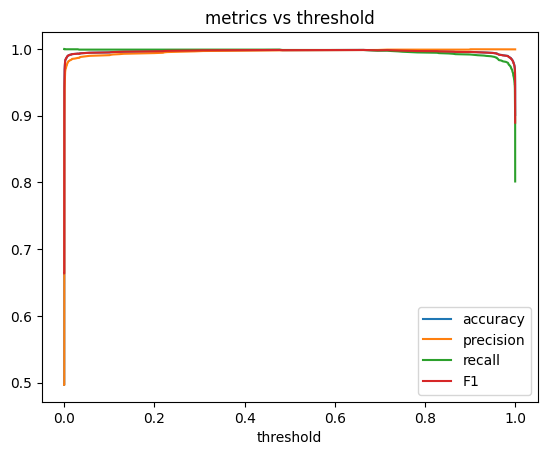

,threshold,maximum
metric,,
accuracy,4.777347e-01,0.998439
precision,9.007957e-01,0.999472
recall,-9.997581e-07,1.000000
F1,4.777347e-01,0.998429


In [38]:
y_val_proba = np.transpose(clf.predict(X_val))[1]
report_metrics = plot_metrics(np.transpose(y_val)[1], y_val_proba, report_max=True)
report_metrics.set_index('metric', inplace=True)
display(report_metrics)

In [39]:
threshold = report_metrics.loc['accuracy', 'threshold']
display_results(y_test, y_proba_softvote > threshold, title='softvoter with threshold = %.5f'%threshold)

Classification report for: softvoter with threshold = 0.47773
Confusion matrix


,human,AI
predicted human,2409,5
predicted AI,3,2332


Metrics:
	accuracy: 0.9983154348283849
	precision: 0.9978605049208387
	recall: 0.9987152034261242
	F1: 0.9982876712328766
Misclassified samples:


,text,source,topic,label
108,"The Man with the Golden Arm, Otto Preminger's ...",imdb,movie review,0
843,"Now I'm 20 years old. When I was 12, I was mol...",r/relationship_advice,My boyfriend's(M20) insensitive response to my...,0
856,I (31f) and my boyfriend (33m) have been toget...,r/relationship_advice,"After an argument, my [31f] live-in boyfriend ...",0
954,"Hey Reddit,\n\nI'm in a bit of a pickle with ...",r/relationship_advice,How to Balance Gaming and Relationship Dynamic...,0
2242,"Physical therapy (PT), also known as physiothe...",wikipedia,Physiotherapy,0
3695,"A few days ago, I was having a conversation wi...",GPT reddit posts,AITA for saying black dont crack as a non blac...,1
3751,Throwaway account because I don't want this li...,GPT reddit posts,AITA for telling off my MIL for insisting my d...,1
4660,"The Hikurangi Margin, also known as the Hikura...",wikipedia by GPT,Hikurangi Margin,1


The threshold for maximising accuracy is very close to 0.5, so we are unable to improve the accuracy.

## Summary and concluding remarks

We have seen that small language models (only several MB in size) are extraordinarily effective in detecting whether a text was generated by GPT-3.5 Turbo. We explored the use of LSTMs and various attention mechanisms with different dropout rates (0.2, 0.5), embedding dimensions (16, 64) and layer sizes (16, 64), ultimately generating test results for 144 different models. Surprisingly, a basic feedforward network with 16 neurons, no attention layer and embedding dimension of 16 attained an accuracy of over 99.6%, which shows that the challenge is primarily driven by the quality of the training data, rather than the complexity of the model or the use of advanced natural language processing techniques. Nevertheless, we saw a significant increase in accuracy with an ensemble classifier incorporating more complex models, but further testing will be required to determine whether this is statistically significant.

In the model evaluation process, I only used a single validation set consisting of 20% of the training data and focused on comparing the performance of a large range of models. However this evaluation could be improved by using five-fold cross validation instead. More detailed learning rate scheduling for the individual models might also slightly improve performance, since across the 144 different models, only three different learning rate schedulers were used.

Finally I will note that the training data was also quite limited, since only three sources were used for the human data and one large language model for the AI generated data, with minimal prompt engineering. Further testing will be needed to determine how well the models will generalise to text obtained from other sources. While we have trained the models on texts from thousands of different human writers, we have only exposed them to a single LLM, in a sense, with a single "personality," which we have interfaced with via an API. It is probable that much of future AI generated text will be obtained through a web interface, with adjustable chat settings such as temperature, content and language restrictions, the type of emotions or sentiment desired in the output, and even sociolinguistic specificities or levels of imitation of various human writers or celebrity figures. Thus it will be necessary to broaden the parameters of LLM output to improve the generalisation of the models.